# Thapar Summer School - Employee Salary Prediction

In this lab, we are predict the salaries of employee from different fake companies.

Here, the features are explain below:

- `id`: Identity of the employee
- `salary`: (Target Column) Salary of the employee
- `company`: Current Company of the employee
- `department`: Department of the employee
- `age`: Current age of the employee
- `age_when_joined`: Employee's age when joined the company
- `year_in_the_company`: Employee's experience in the company
- `prior_years_experiences`: Employee's experience prior to joining the company
- `annual_bonus`: Annual bonus of employee

## 1. Tools

Now, before we get, let's initialize some important's libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## 2. Viewing the data

Taking a look in our training dataset and getting more familiar with it. Remember that the training dataset and test dataset are already separated.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Looking at the first five examples of the dataset.

In [3]:
df_train.head()

,id,company,department,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,1,Cheerper,Support,40,36,4,69420.46872,22586.99591,2,0.000000,0.893809,0.328591
1,2,Cheerper,BigData,40,34,6,88407.04974,18676.07837,3,0.205947,0.756632,0.036870
2,3,Pear,Sales,41,39,2,97831.84885,19287.87365,2,0.942309,0.000000,0.514457
3,4,Glasses,Search Engine,39,33,6,93905.86813,17936.39297,3,0.484373,0.236922,0.278535
4,5,Glasses,AI,39,35,3,105983.97520,16854.92943,3,0.835346,0.308958,0.000000


Seeing the shape of our dataset.

In [4]:
n_rows = df_train.shape[0]
n_columns = df_train.shape[1]

print(f"The number of rows is: {n_rows}")
print(f"The number of columns is: {n_columns}")

The number of rows is: 100000
The number of columns is: 12


In [5]:
df_train.dtypes

id                          int64
company                    object
department                 object
age                         int64
age_when_joined             int64
years_in_the_company        int64
salary                    float64
annual_bonus              float64
prior_years_experience      int64
full_time                 float64
part_time                 float64
contractor                float64
dtype: object

Checking if the dataframe has some null value.

In [6]:
df_train.isnull().sum()

id                        0
company                   0
department                0
age                       0
age_when_joined           0
years_in_the_company      0
salary                    0
annual_bonus              0
prior_years_experience    0
full_time                 0
part_time                 0
contractor                0
dtype: int64

That's good. Now, we notice that just two features are categorical (`company` and `department`), while the others are numerical (without considerer `id`). Let's see the different values that each of the two feature contains.

#### Values in _company_ and _department_

In [7]:
df_train['company'].value_counts()

Glasses     47734
Cheerper    28583
Pear        23683
Name: company, dtype: int64

In [8]:
df_train['department'].value_counts()

Search Engine    21915
AI               21642
BigData          15777
Design           15713
Sales            12535
Support          12418
Name: department, dtype: int64

In [9]:
df_train.describe(include=object)

,company,department
count,100000,100000
unique,3,6
top,Glasses,Search Engine
freq,47734,21915


#### Summary measures of each numerical feature

In [10]:
df_train.describe(include=[int, float])

,id,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,38.195870,33.537060,4.667780,87389.018245,18582.064815,2.505540,0.383531,0.383279,0.382016
std,28867.657797,6.013073,7.719078,2.531773,28478.542805,4373.431365,1.207222,0.340638,0.339783,0.339621
min,1.000000,30.000000,22.000000,1.000000,40000.000000,9000.000000,1.000000,0.000000,0.000000,0.000000
25%,25000.750000,33.000000,27.000000,3.000000,66027.961360,15448.885482,1.000000,0.016171,0.015702,0.013575
50%,50000.500000,38.000000,33.000000,5.000000,86554.204990,18821.651785,2.000000,0.333278,0.334739,0.331437
75%,75000.250000,43.000000,39.000000,7.000000,107269.920325,22168.522630,3.000000,0.653879,0.650733,0.649338
max,100000.000000,49.000000,48.000000,9.000000,153000.000000,24792.910000,5.000000,1.000000,1.000000,1.000000


For we will start the data pre-processing, we know that categorical features like **company** and **department** have a lower cardinality, which can be managed by some **encoding** techniques. 

Also, we know that the others features (which are numerical) are having **high deviation** values which can lead to bias, overfitting, and can affect the accuracy of the model. So, we can use some different transformation techniques to reduce the deviation between the data-points.

## 3. Data pre-processing

Notice that the column `id` only represents the _index_ of a employee. So, as it appears to be irrelevant to analysis, we can simply **drop the feature**.

In [11]:
df_train = df_train.drop(columns='id')

#### Separating numerical features and categorical features

In [12]:
# taking only numerical features
num_feat = df_train.drop(columns=['company', 'department', 'salary'])

# taking only categorical features
cat_feat = df_train.loc[:, ['company', 'department']]

#### Processing the categorical features using OneHotEnconder

In [13]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# label encoded values of company and department
enc_df = pd.DataFrame(enc.fit_transform(cat_feat[['company', 'department']]).toarray(), columns=enc.get_feature_names(['company', 'department']))
enc_df.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Feature scaling using StandardScale

Notice that, for example, the numerical feature `annual_bonus` have a large scale of values, so, as not to affect the performance of the model and avoid convergence problems for models based on gradients.

In [14]:
# creating a instance of StandardScaler
scaler = StandardScaler()

# applying StandardScaler only to features
num_feat_norm = scaler.fit_transform(num_feat)

# converting normalized output to a new DataFrame
feat_norm_df = pd.DataFrame(num_feat_norm, columns=num_feat.columns)
feat_norm_df.head()

,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308
1,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274
2,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967
3,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698
4,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837


Taking only the target `salary` of dataframe `df_train` to concat with the others df's.

In [15]:
# taking the target
target_df = df_train.loc[:,'salary']

# concatenating the df's of preprocessed numerical and categorical features
all_features = pd.concat([enc_df, feat_norm_df], axis=1)

# concatening the df's of all features with the target
df_train = pd.concat([all_features, target_df], axis=1)
df_train.head()

,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor,salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308,69420.46872
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274,88407.04974
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967,97831.84885
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698,93905.86813
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837,105983.97520


In [16]:
df_train.shape

(100000, 18)

In [17]:
df_train.dtypes

company_Cheerper            float64
company_Glasses             float64
company_Pear                float64
department_AI               float64
department_BigData          float64
department_Design           float64
department_Sales            float64
department_Search Engine    float64
department_Support          float64
age                         float64
age_when_joined             float64
years_in_the_company        float64
annual_bonus                float64
prior_years_experience      float64
full_time                   float64
part_time                   float64
contractor                  float64
salary                      float64
dtype: object

#### Separating X_train | y_train and X_cv | y_cv

Today, we know that there are a variety of regression algorithms and a instead to put our focus in only one of those algorithms, it's would be better have some other dataset to realize a cross validation and use them to evaluate different configurations of model. With that, we be able to choose the better model through some metrics like R2 Score and some error functions.

In [18]:
feat_train, targ_train = df_train.drop(columns='salary'), df_train.loc[:, 'salary']
X_train, X_cv, y_train, y_cv = train_test_split(feat_train, targ_train, test_size=0.2, random_state=0)

In [19]:
print("Dimension of X_train =>", X_train.shape)
print("Dimension of X_cv =>", X_cv.shape)
print("Dimension of y_train =>", y_train.shape)
print("Dimension of y_cv =>", y_cv.shape)

Dimension of X_train => (80000, 17)
Dimension of X_cv => (20000, 17)
Dimension of y_train => (80000,)
Dimension of y_cv => (20000,)


#### Doing all preprocessing to the df of the test and obtaining X_test

In [21]:
# drop id
df_test = df_test.drop(columns='id')

# separate the numerical features and categorical features
num_feat_test = df_test.drop(columns=['company', 'department'])
cat_feat_test = df_test.loc[:, ['company', 'department']]

# OneHotEncoder
enc_test = OneHotEncoder(handle_unknown='ignore')
enc_test_df = pd.DataFrame(enc_test.fit_transform(cat_feat_test[['company', 'department']]).toarray(), columns=enc_test.get_feature_names(['company', 'department']))

# Feature scaling
num_feat_norm_test = scaler.fit_transform(num_feat_test)
feat_norm_df_test = pd.DataFrame(num_feat_norm_test, columns=num_feat_test.columns)

# concatenating the df's of preprocessed numerical and categorical features of test
X_test = pd.concat([enc_test_df, feat_norm_df_test], axis=1)
X_test.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.117167,1.859593,-1.442821,-2.176168,1.239771,-1.127529,-0.653535,1.811299
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.452452,1.083241,-1.442821,-0.367324,1.239771,0.254885,-1.126316,0.999501
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.876979,-1.375206,1.718193,-0.898164,1.239771,-0.129338,1.118517,-1.129061
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.710800,-0.598855,0.137686,0.977069,-0.415398,1.799037,-1.126316,0.075396
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.618631,0.953849,-1.442821,-0.665359,-0.415398,-1.127529,0.997430,0.616834


## 4. Model Creation & Evaluation

We will create a function to train model using different regression algorithms.

In [22]:
r2_value = []
adjusted_r2_value = []
mae_value = []
mse_value = []
rmse_value = []

In [26]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_train_pred= model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    #Metrics Calculation.
    mae = mean_absolute_error(y_cv,y_cv_pred)
    mse = mean_squared_error(y_cv,y_cv_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_cv,y_cv_pred)
    adjusted_r2 = 1 - ((1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
   
    mae_value.append(mae)
    mse_value.append(mse)
    rmse_value.append(rmse)
    r2_value.append(r2)
    adjusted_r2_value.append(adjusted_r2) 
    
    print(f"R2 Score of the {model} model is=>",r2)
    print(f"Adjusted R2 Score of the {model} model is=>",adjusted_r2)
    print()
    print(f"MAE of {model} model is=>",mae)
    print(f"MSE of {model} model is=>",mse)
    print(f"RMSE of {model} model is=>",rmse)
    

    # Scatter plot.
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)    
    plt.scatter(y_train, y_train_pred, color='blue', label='Train')
    plt.scatter(y_cv, y_cv_pred, color='red', label='Test')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot',fontweight="black",size=20,pad=10)
    
    # Residual plot.
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', label='Train')
    plt.scatter(y_cv_pred, y_cv_pred - y_cv, color='red', label='Test')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title('Residual Plot',fontweight="black",size=20,pad=10)
    plt.show()

#### Creating a LinearRegression Model

R2 Score of the LinearRegression() model is=> 0.6887394442129928
Adjusted R2 Score of the LinearRegression() model is=> 0.6886335775120129

MAE of LinearRegression() model is=> 12731.300194108499
MSE of LinearRegression() model is=> 251835239.21168736
RMSE of LinearRegression() model is=> 15869.317540829768


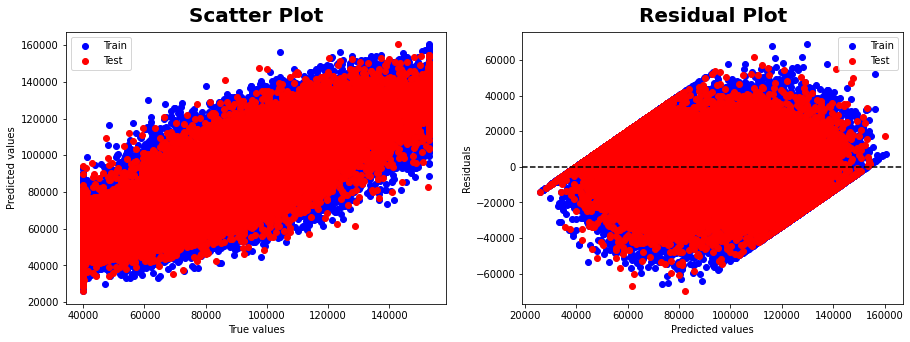

In [27]:
model_evaluation(LinearRegression())

#### Creating a SGDRegressor Model

R2 Score of the SGDRegressor() model is=> 0.6882600371196841
Adjusted R2 Score of the SGDRegressor() model is=> 0.6881540073615919

MAE of SGDRegressor() model is=> 12737.47628034414
MSE of SGDRegressor() model is=> 252223118.7479104
RMSE of SGDRegressor() model is=> 15881.533891532972


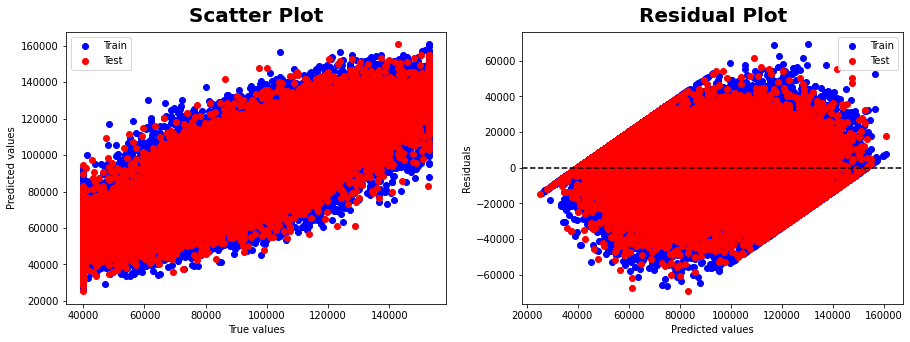

In [28]:
model_evaluation(SGDRegressor(max_iter=1000))

#### Creating a GradientBoostingRegressor Model

R2 Score of the GradientBoostingRegressor() model is=> 0.7143994135459177
Adjusted R2 Score of the GradientBoostingRegressor() model is=> 0.7143022743764224

MAE of GradientBoostingRegressor() model is=> 12237.214099012463
MSE of GradientBoostingRegressor() model is=> 231074225.98666552
RMSE of GradientBoostingRegressor() model is=> 15201.125813131917


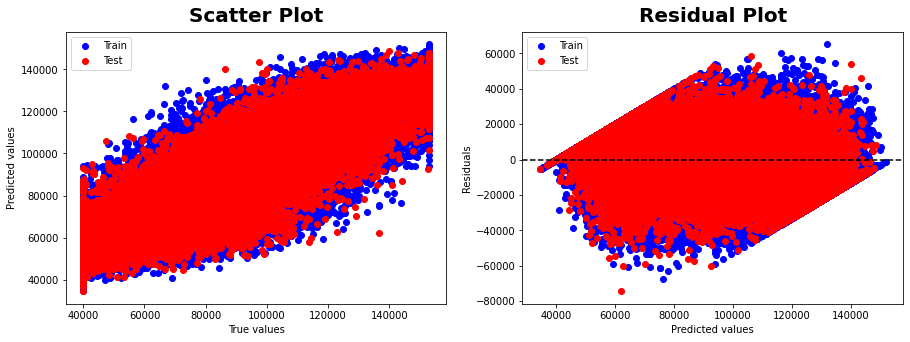

In [32]:
model_evaluation(GradientBoostingRegressor())

#### Creating a RandomForestRegressor Model

R2 Score of the RandomForestRegressor() model is=> 0.705869419636068
Adjusted R2 Score of the RandomForestRegressor() model is=> 0.7057693792241959

MAE of RandomForestRegressor() model is=> 12281.145945825554
MSE of RandomForestRegressor() model is=> 237975688.497165
RMSE of RandomForestRegressor() model is=> 15426.460660085482


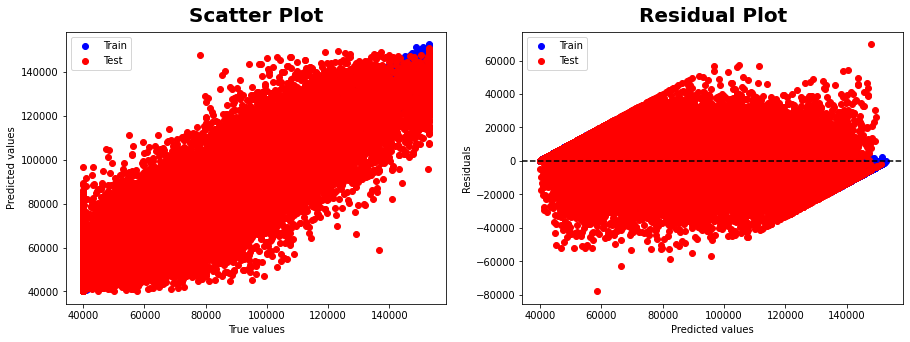

In [29]:
model_evaluation(RandomForestRegressor())

####  Creating a AdaBoostRegressor Model

R2 Score of the AdaBoostRegressor() model is=> 0.6140600431007464
Adjusted R2 Score of the AdaBoostRegressor() model is=> 0.6139287762593377

MAE of AdaBoostRegressor() model is=> 14459.35161327121
MSE of AdaBoostRegressor() model is=> 312256980.7193313
RMSE of AdaBoostRegressor() model is=> 17670.794569552647


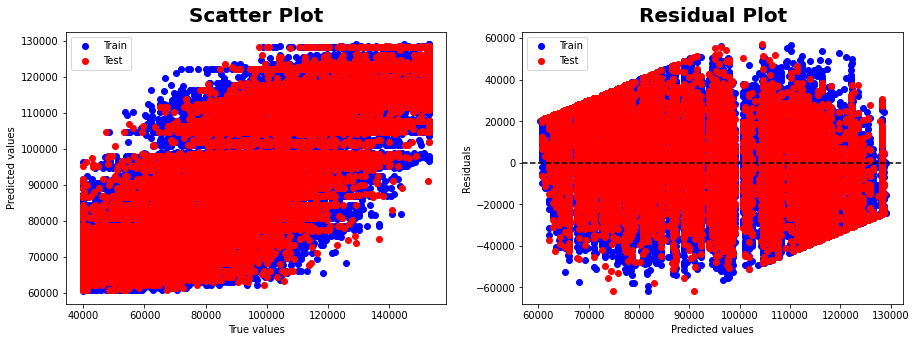

In [33]:
model_evaluation(AdaBoostRegressor())

#### Creating a XGBRegressor Model

R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model is=> 0.7281828862995113
Adjusted R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
    

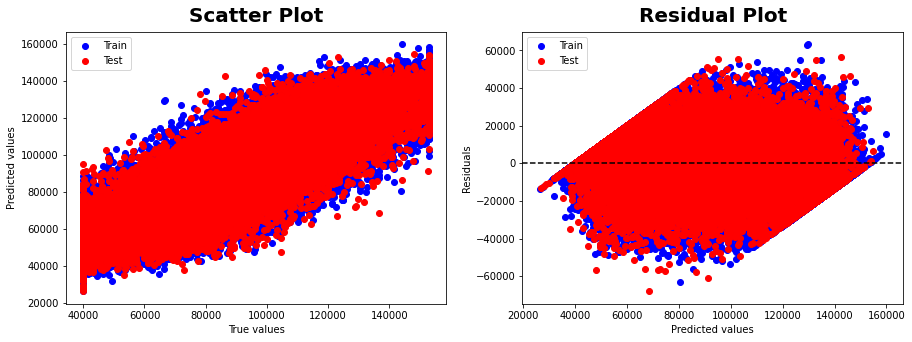

In [30]:
model_evaluation(XGBRegressor())

#### Creating a CatBoostRegressor Model

Learning rate set to 0.081822
0:	learn: 27116.4010602	total: 149ms	remaining: 2m 28s
1:	learn: 25890.4528910	total: 154ms	remaining: 1m 17s
2:	learn: 24786.9983415	total: 160ms	remaining: 53.2s
3:	learn: 23814.7750117	total: 166ms	remaining: 41.3s
4:	learn: 22934.2813062	total: 172ms	remaining: 34.2s
5:	learn: 22148.7043883	total: 177ms	remaining: 29.2s
6:	learn: 21437.0793642	total: 181ms	remaining: 25.7s
7:	learn: 20816.7429297	total: 186ms	remaining: 23.1s
8:	learn: 20281.4416094	total: 191ms	remaining: 21.1s
9:	learn: 19799.2674840	total: 196ms	remaining: 19.4s
10:	learn: 19376.3058853	total: 201ms	remaining: 18.1s
11:	learn: 18987.4473681	total: 206ms	remaining: 16.9s
12:	learn: 18649.1678429	total: 210ms	remaining: 16s
13:	learn: 18369.2924471	total: 215ms	remaining: 15.1s
14:	learn: 18105.5529317	total: 219ms	remaining: 14.4s
15:	learn: 17863.4663226	total: 223ms	remaining: 13.7s
16:	learn: 17659.5785258	total: 227ms	remaining: 13.1s
17:	learn: 17486.1903435	total: 232ms	remaini

174:	learn: 14646.1723829	total: 1.05s	remaining: 4.93s
175:	learn: 14643.3908327	total: 1.05s	remaining: 4.93s
176:	learn: 14641.0386698	total: 1.06s	remaining: 4.92s
177:	learn: 14638.2538622	total: 1.06s	remaining: 4.92s
178:	learn: 14635.7218785	total: 1.07s	remaining: 4.92s
179:	learn: 14633.9283587	total: 1.08s	remaining: 4.91s
180:	learn: 14631.5824531	total: 1.09s	remaining: 4.91s
181:	learn: 14629.4376649	total: 1.09s	remaining: 4.91s
182:	learn: 14627.2945910	total: 1.1s	remaining: 4.9s
183:	learn: 14625.3099912	total: 1.1s	remaining: 4.9s
184:	learn: 14623.1254700	total: 1.11s	remaining: 4.9s
185:	learn: 14621.4349005	total: 1.12s	remaining: 4.9s
186:	learn: 14619.1755036	total: 1.13s	remaining: 4.89s
187:	learn: 14617.0246458	total: 1.13s	remaining: 4.89s
188:	learn: 14614.7431263	total: 1.14s	remaining: 4.88s
189:	learn: 14612.1296856	total: 1.14s	remaining: 4.88s
190:	learn: 14609.8244481	total: 1.15s	remaining: 4.88s
191:	learn: 14607.7595438	total: 1.16s	remaining: 4.88

344:	learn: 14396.1775218	total: 1.94s	remaining: 3.69s
345:	learn: 14395.3690010	total: 1.95s	remaining: 3.68s
346:	learn: 14394.4182923	total: 1.95s	remaining: 3.67s
347:	learn: 14393.6118916	total: 1.96s	remaining: 3.67s
348:	learn: 14392.7580226	total: 1.96s	remaining: 3.66s
349:	learn: 14391.4718908	total: 1.97s	remaining: 3.65s
350:	learn: 14390.3402249	total: 1.97s	remaining: 3.64s
351:	learn: 14389.4600704	total: 1.98s	remaining: 3.64s
352:	learn: 14388.4403422	total: 1.98s	remaining: 3.63s
353:	learn: 14387.6860011	total: 1.98s	remaining: 3.62s
354:	learn: 14386.6615270	total: 1.99s	remaining: 3.61s
355:	learn: 14385.8439478	total: 1.99s	remaining: 3.61s
356:	learn: 14384.7791600	total: 2s	remaining: 3.6s
357:	learn: 14383.7625773	total: 2s	remaining: 3.59s
358:	learn: 14382.8083845	total: 2.01s	remaining: 3.58s
359:	learn: 14382.1238520	total: 2.01s	remaining: 3.58s
360:	learn: 14381.0761334	total: 2.02s	remaining: 3.57s
361:	learn: 14380.1254531	total: 2.02s	remaining: 3.56s

521:	learn: 14246.6336834	total: 2.84s	remaining: 2.6s
522:	learn: 14245.8664107	total: 2.84s	remaining: 2.59s
523:	learn: 14245.0045668	total: 2.85s	remaining: 2.59s
524:	learn: 14244.3823425	total: 2.86s	remaining: 2.58s
525:	learn: 14243.8068098	total: 2.86s	remaining: 2.58s
526:	learn: 14243.1193619	total: 2.87s	remaining: 2.57s
527:	learn: 14242.4269324	total: 2.87s	remaining: 2.57s
528:	learn: 14241.6180749	total: 2.88s	remaining: 2.56s
529:	learn: 14240.8580291	total: 2.88s	remaining: 2.56s
530:	learn: 14239.8066969	total: 2.89s	remaining: 2.55s
531:	learn: 14239.1892431	total: 2.9s	remaining: 2.55s
532:	learn: 14238.4975647	total: 2.9s	remaining: 2.54s
533:	learn: 14237.5424050	total: 2.91s	remaining: 2.54s
534:	learn: 14236.9250747	total: 2.91s	remaining: 2.53s
535:	learn: 14236.0537958	total: 2.92s	remaining: 2.52s
536:	learn: 14235.5585587	total: 2.92s	remaining: 2.52s
537:	learn: 14234.6040744	total: 2.93s	remaining: 2.52s
538:	learn: 14233.9456993	total: 2.93s	remaining: 2

698:	learn: 14125.4663939	total: 3.73s	remaining: 1.61s
699:	learn: 14124.7643336	total: 3.74s	remaining: 1.6s
700:	learn: 14124.0907202	total: 3.74s	remaining: 1.6s
701:	learn: 14123.3399048	total: 3.75s	remaining: 1.59s
702:	learn: 14122.9088686	total: 3.75s	remaining: 1.59s
703:	learn: 14122.1777370	total: 3.76s	remaining: 1.58s
704:	learn: 14121.3461047	total: 3.77s	remaining: 1.58s
705:	learn: 14120.6790641	total: 3.77s	remaining: 1.57s
706:	learn: 14119.9701613	total: 3.78s	remaining: 1.57s
707:	learn: 14119.2629451	total: 3.79s	remaining: 1.56s
708:	learn: 14118.6757561	total: 3.79s	remaining: 1.56s
709:	learn: 14118.3785707	total: 3.8s	remaining: 1.55s
710:	learn: 14117.6524693	total: 3.82s	remaining: 1.55s
711:	learn: 14117.0411524	total: 3.82s	remaining: 1.55s
712:	learn: 14116.3173110	total: 3.83s	remaining: 1.54s
713:	learn: 14115.7315670	total: 3.83s	remaining: 1.53s
714:	learn: 14115.2258621	total: 3.84s	remaining: 1.53s
715:	learn: 14114.5360684	total: 3.84s	remaining: 1

870:	learn: 14018.0278188	total: 4.64s	remaining: 687ms
871:	learn: 14017.4050222	total: 4.64s	remaining: 682ms
872:	learn: 14016.7298411	total: 4.65s	remaining: 676ms
873:	learn: 14015.9295592	total: 4.66s	remaining: 672ms
874:	learn: 14015.4265277	total: 4.67s	remaining: 667ms
875:	learn: 14014.7399124	total: 4.67s	remaining: 661ms
876:	learn: 14014.1427690	total: 4.68s	remaining: 656ms
877:	learn: 14013.4960751	total: 4.68s	remaining: 651ms
878:	learn: 14013.0230093	total: 4.69s	remaining: 645ms
879:	learn: 14012.4956068	total: 4.69s	remaining: 640ms
880:	learn: 14011.8860809	total: 4.7s	remaining: 635ms
881:	learn: 14011.1420021	total: 4.7s	remaining: 629ms
882:	learn: 14010.3459564	total: 4.71s	remaining: 624ms
883:	learn: 14009.8407686	total: 4.71s	remaining: 618ms
884:	learn: 14009.4846436	total: 4.72s	remaining: 613ms
885:	learn: 14009.0661127	total: 4.72s	remaining: 607ms
886:	learn: 14008.6626564	total: 4.72s	remaining: 602ms
887:	learn: 14008.1241555	total: 4.73s	remaining: 

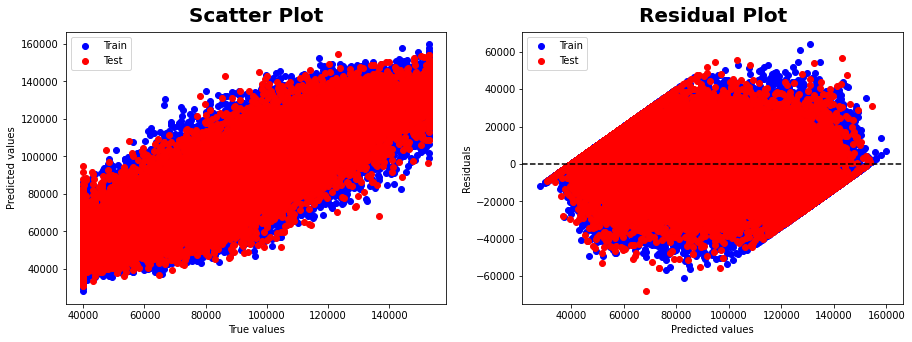

In [31]:
model_evaluation(CatBoostRegressor())